In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

In [28]:
df=pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\Short-Term WTI Price Forecasting\Temp prediction\Data.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df['Texas'] = pd.to_numeric(df['Texas'])
df = df.sort_values(by='DATE', ascending=True)
df = df.set_index('DATE')
df = df.drop(columns=['Dubai','UK','Dubai Price','WTI', 'Brent'])
df = df.asfreq(pd.infer_freq(df.index))
df = df.resample('W').mean()
df = df.dropna()
df

,Texas
DATE,
2020-07-12,26.875
2020-07-19,28.960
2020-07-26,26.940
2020-08-02,27.340
2020-08-09,29.400
...,...
2024-08-11,27.650
2024-08-18,29.500
2024-08-25,30.100


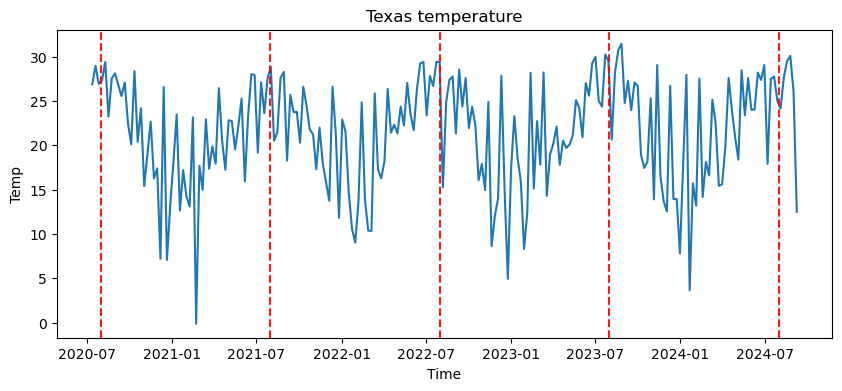

In [29]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('Texas temperature')
plt.xlabel('Time')
plt.ylabel('Temp')
for year in range(2020,2025):
    plt.axvline(pd.to_datetime(str(year)+'-07-31'),color='r',linestyle='--',alpha=0.9)

In [30]:
first_diff = df.diff(periods=52)
first_diff = first_diff.dropna()
first_diff

,Texas
DATE,
2021-07-25,0.725
2021-08-01,-0.140
2021-08-08,-6.420
2021-08-15,-5.880
2021-08-22,-1.780
...,...
2024-08-11,-0.575
2024-08-18,-1.220
2024-08-25,-1.360


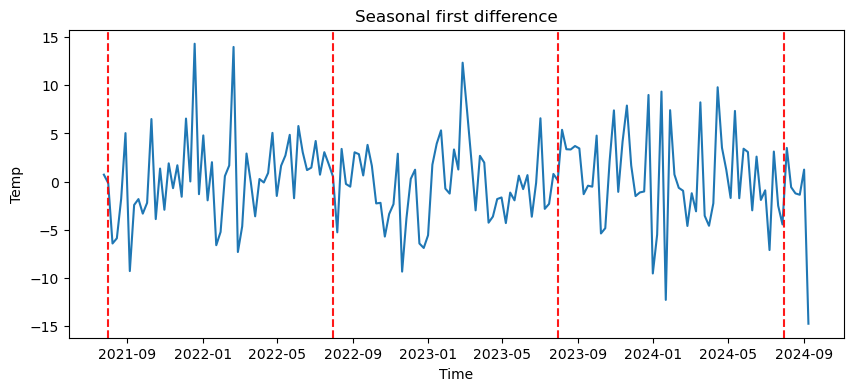

In [31]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Seasonal first difference')
plt.xlabel('Time')
plt.ylabel('Temp')
for year in range(2021,2025):
    plt.axvline(pd.to_datetime(str(year)+'-07-31'),color='r',linestyle='--',alpha=0.9)

In [32]:
result = adfuller(first_diff)
p_value = result[1]
formatted_p_value = "{:.2f}".format(p_value) #int 2 deicimal places
print("p-value:", formatted_p_value)

p-value: 0.00


In [33]:
print(len(first_diff))

164


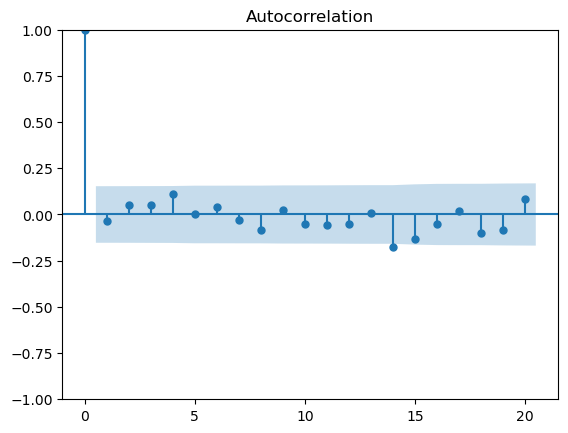

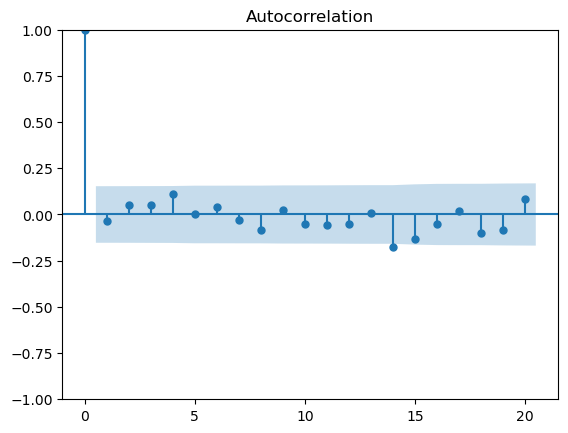

In [34]:
plot_acf(first_diff, lags=20)

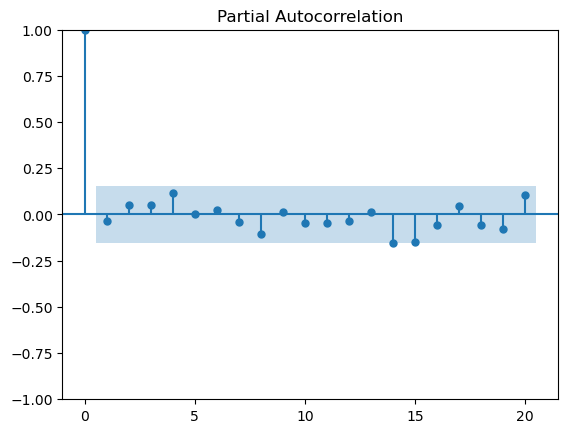

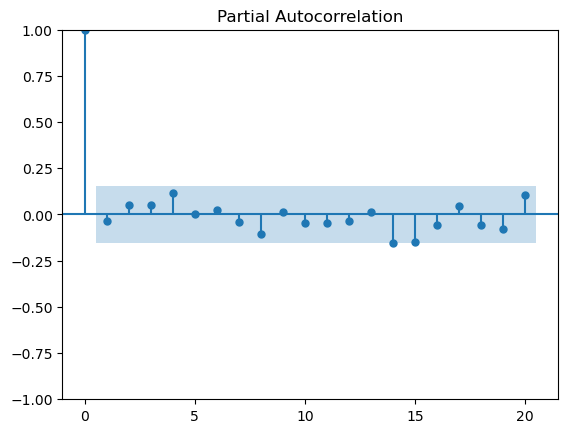

In [35]:
plot_pacf(first_diff, lags=20)

In [36]:
train_end = datetime(2024,5,31)

train_data=df[:train_end]
test_data=df[train_end + timedelta(days=1):]
test_data

,Texas
DATE,
2024-06-02,24.000
2024-06-09,24.040
2024-06-16,28.200
2024-06-23,27.375
2024-06-30,29.060
2024-07-07,17.900
2024-07-14,27.500
2024-07-21,27.740
2024-07-28,25.060


In [37]:
ar_orders = range(1,5)
ma_orders = range(1,5)
fitted_model_dict = {}

for ar_order in ar_orders:
    for ma_order in ma_orders:    

        arima_model = SARIMAX(train_data, order = (0,0,0), seasonal_order = (ar_order,1,ma_order,52))
        arima_model_fit = arima_model.fit()
        fitted_model_dict[(ar_order, ma_order)] = arima_model_fit #this saves the model_fit to the right key like AR(1) to 1 AR(4) to 4

lowest_bic = float('inf')
best_order = None

for ar_order in ar_orders:
    for ma_order in ma_orders:
        bic_value = fitted_model_dict[(ar_order, ma_order)].bic #arima_model_fit.bic
        if bic_value < lowest_bic:
            lowest_bic = bic_value
            best_order = (ar_order, ma_order)

print(f'Lowest BIC: {lowest_bic} for AR({best_order[0]}) and MA({best_order[1]})')

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignore

Lowest BIC: 872.3954506717954 for AR(1) and MA(1)


In [38]:
model = SARIMAX(train_data, order=(0,0,0) , seasonal_order=(1,1,1,52))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                 SARIMAX Results                                  
Dep. Variable:                      Texas   No. Observations:                  201
Model:             SARIMAX(1, 1, [1], 52)   Log Likelihood                -428.692
Date:                    Fri, 04 Oct 2024   AIC                            863.384
Time:                            19:43:01   BIC                            872.395
Sample:                                 0   HQIC                           867.045
                                    - 201                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52       0.0922      0.413      0.223      0.824      -0.718       0.903
ma.S.L52      -0.5261      0.488     -1.078      0.281      -1.483       0.431
sigma2        17.066

In [39]:
rolling_predictions=pd.Series(index=test_data.index)

for i in test_data.index:
    train_data = df[:i-timedelta(days=1)] #slicing when dealing with datetime is inclusive man so minus one day
    model = SARIMAX(train_data, order = (0,0,0), seasonal_order = (1,1,1,52))
    model_fit = model.fit()
    prediction = model_fit.forecast(1)
    rolling_predictions.loc[i] = prediction.item()
rolling_predictions

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at

DATE
2024-06-02    20.225745
2024-06-09    26.259382
2024-06-16    26.897900
2024-06-23    29.081246
2024-06-30    26.478493
2024-07-07    26.026546
2024-07-14    24.798772
2024-07-21    29.558147
2024-07-28    29.354781
2024-08-04    19.924841
2024-08-11    26.720424
2024-08-18    29.622970
2024-08-25    29.319715
2024-09-01    23.810677
2024-09-08    27.383908
dtype: float64

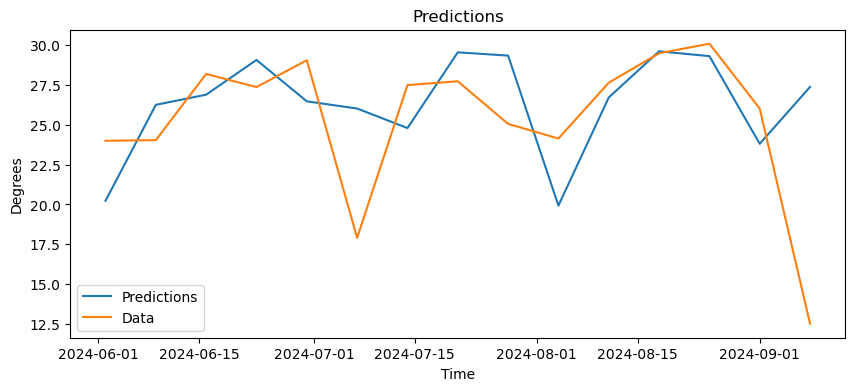

In [40]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions, label='Predictions')
plt.plot(test_data, label='Data')
plt.title('Predictions')
plt.xlabel('Time')
plt.ylabel('Degrees')
plt.legend()

Text(0, 0.5, 'Degrees')

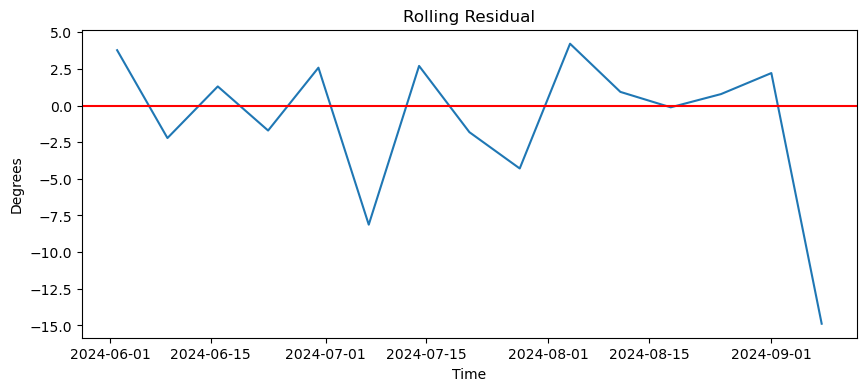

In [41]:
rolling_residual = test_data['Texas'] - rolling_predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residual)
plt.axhline(y=0, color = 'r')
plt.title('Rolling Residual')
plt.xlabel('Time')
plt.ylabel('Degrees')

In [42]:
print('Mean abs % error:',np.mean(abs(rolling_residual/test_data['Texas'])))

Mean abs % error: 0.18334560090603913


In [43]:
print('Root mean squared error (degrees):',np.sqrt(np.mean(rolling_residual**2)))

Root mean squared error (degrees): 4.974731837355614
